# Set Parameter
- Attention = None
- Drop out = 0.2
- Teacher Forcing Ratio = 0.5
- Layer = 2
- Hidden unit = 50
- Batch size = 32
- Epochs = 50

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


# Data load

In [2]:
train_path = "data/grammar_data_N100_train.txt"
dev_path = "data/grammar_data_N100_test.txt"
log_level = 'info'

# Log format

In [3]:
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Prepare dataset

In [4]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 102
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Prepare loss

In [5]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Variable definition

In [6]:
seq2seq = None
optimizer = "Adam"

hidden_sizes = list(range(50, 51, 4))
print(hidden_sizes)
error_rate = []
accuracy = []
losses = []

[50]


# Initialize model

2019-01-29 17:38:30,906 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Hidden size is 50


2019-01-29 17:45:00,462 INFO   Finished epoch 1: Train loss: 15.3642, Dev loss: 7.1491, Accuracy(Character): 0.3951, Accuracy(Word): 0.0000
2019-01-29 17:51:26,751 INFO   Finished epoch 2: Train loss: 3.5362, Dev loss: 8.6000, Accuracy(Character): 0.3943, Accuracy(Word): 0.0000
2019-01-29 17:57:59,038 INFO   Finished epoch 3: Train loss: 2.7303, Dev loss: 2.9259, Accuracy(Character): 0.5888, Accuracy(Word): 0.0000
2019-01-29 18:04:29,196 INFO   Finished epoch 4: Train loss: 2.4506, Dev loss: 2.8308, Accuracy(Character): 0.5928, Accuracy(Word): 0.0000
2019-01-29 18:10:54,316 INFO   Finished epoch 5: Train loss: 2.1698, Dev loss: 2.7306, Accuracy(Character): 0.6178, Accuracy(Word): 0.0000
2019-01-29 18:17:32,380 INFO   Finished epoch 6: Train loss: 2.0153, Dev loss: 3.9553, Accuracy(Character): 0.5505, Accuracy(Word): 0.0053
2019-01-29 18:24:01,997 INFO   Finished epoch 7: Train loss: 1.9632, Dev loss: 2.1666, Accuracy(Character): 0.6802, Accuracy(Word): 0.0059
2019-01-29 18:30:24,736 IN

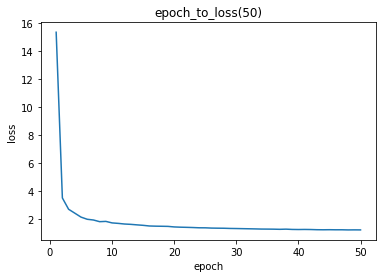

In [8]:
for i in hidden_sizes:
    print("Hidden size is %d" % i)
    hidden_size = i
    bidirectional = True
    encoder = EncoderRNN(len(src.vocab), max_len, hidden_size, n_layers=2,
                        bidirectional=bidirectional, variable_lengths=True)
    decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                        dropout_p=0.2, n_layers=2,use_attention=False, bidirectional=bidirectional,
                        eos_id=tgt.eos_id, sos_id=tgt.sos_id)
    seq2seq = Seq2seq(encoder, decoder)
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    t = SupervisedTrainer(loss=loss, batch_size=32,
                        checkpoint_every=50,
                        print_every=100)

    seq2seq, ave_loss, character_accuracy = t.train(seq2seq, train,
                                                    num_epochs=50, dev_data=dev,
                                                    optimizer=optimizer,
                                                    teacher_forcing_ratio=0.5)

    losses.append(ave_loss/100)
    error_rate.append(1 - character_accuracy)
    accuracy.append(character_accuracy)

In [9]:
torch.save(seq2seq.state_dict(), 'log/100N_no_att_model_save.pth')